In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())
# download the MNIST database

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


image.shape: torch.Size([1, 28, 28])
Label: 5


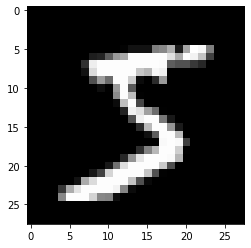

In [ ]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image[0, 0:28, 0:28], cmap='gray')
print('Label:', label)
# test if the image is displaying

In [ ]:
train_size = len(dataset)
# initialise the size of validation set as 10000 and training set as 50000

batch_size = 128
train_dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
# load training data

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class Train(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def display_loss_and_acc(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)
        return {'loss': loss.detach(), 'accuracy': acc}


    def losses_and_accuracies_epoch_end(self, outputs):
        batch_losses = [x['loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['accuracy'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        # calculating mean accuracies and losses of all batches at the end of epoch

        return {'loss': epoch_loss.item(), 'accuracy': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], loss: {:.4f}, accuracy: {:.4f}".format(epoch, result['loss'], result['accuracy']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class MnistModel(Train):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 14 x 14

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 7 x 7

            # FC part:
            nn.Flatten(), 
            nn.Linear(128*7*7, 784), # input layer for FC
            nn.ReLU(),
            nn.Linear(784, 512), # hidden layer for FC
            nn.ReLU(),
            nn.Linear(512, 10)) # output layer for FC and the entire model
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = MnistModel()
model
# checking if model works

MnistModel(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=6272, out_features=784, bias=True)
    (12): ReLU()
    (13): Linear(in_features=784, out_features=512, bias=True)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [ ]:
# USING GPU (IF PRESENT)

def get_default_device():
  # Pick GPU if available
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  # Move tensors to chosen device
  if isinstance(data, (list, tuple)):
    # if data is a list/tuple
    return [to_device(x, device) for x in data]
    # load each data to device
  return data.to(device, non_blocking=True)
  # loads the data to the device

class DeviceDataLoader():
  # wrap dataloader to move data to device
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    # create an iterative function to iterate through the instance
    # yield a batch of data after moving it to device
    for b in self.dl:
      yield to_device(b, self.device)
      # load data to device

  def __len__(self):
    # number of batches
    return len(self.dl)

In [ ]:
# @torch.no_grad() is a context-manager that disables gradient calculation.
# Disabling gradient calculation is useful for inference
# It will reduce memory consumption for computations that would otherwise have requires_grad=True.
@torch.no_grad()
def evaluate(model, train_dataloader):
  model.train()
  outputs = [model.display_loss_and_acc(batch) for batch in train_dataloader]
  return model.losses_and_accuracies_epoch_end(outputs)
  # return values of losses and accuracies at end of epoch

def fit(epochs, lr, model, train_dataloader, opt_func = torch.optim.SGD):
  history = []
  # contains training losses, val losses, accuracies for each epoch
  optimizer = opt_func(model.parameters(), lr)
  # optimizer is used to update weights and biases
  for epoch in range(epochs):
    # training phase
    model.train()
    train_losses = []
    for batch in train_dataloader:
      loss = model.training_step(batch)
      # find loss
      train_losses.append(loss)
      loss.backward()
      # find gradients
      optimizer.step()
      # perform gradient descent
      optimizer.zero_grad()

    result = evaluate(model, train_dataloader)
    # result will display losses and accuracies
    result['loss'] = torch.stack(train_losses).mean().item()
    # for each epoch, display the mean of the training losses
    model.epoch_end(epoch, result)
    history.append(result)
  return history
  # array that stores the epoch number, losses and accuracies

In [ ]:
device = get_default_device()
device
# check if gpu is available (I ran this on colab so outputs cuda)

device(type='cuda')

In [ ]:
train_dataloader = DeviceDataLoader(train_dataloader, device)
to_device(model, device)
# check if loading into device worked

MnistModel(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=6272, out_features=784, bias=True)
    (12): ReLU()
    (13): Linear(in_features=784, out_features=512, bias=True)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [ ]:
evaluate(model, train_dataloader)
# check if evaluate() works

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


{'accuracy': 0.09913600981235504, 'loss': 2.302206039428711}

In [ ]:
model = to_device(MnistModel(), device)
# create model and load to device
num_epochs = 20
# number of epochs
opt_func = torch.optim.Adam
lr = 0.001
# learning rate, i.e., amount each weight and bias is changed per batch

In [ ]:
history = fit(num_epochs, lr, model, train_dataloader, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], loss: 0.1863, accuracy: 0.9832
Epoch [1], loss: 0.0445, accuracy: 0.9885
Epoch [2], loss: 0.0284, accuracy: 0.9956
Epoch [3], loss: 0.0226, accuracy: 0.9963
Epoch [4], loss: 0.0151, accuracy: 0.9972
Epoch [5], loss: 0.0143, accuracy: 0.9968
Epoch [6], loss: 0.0121, accuracy: 0.9961
Epoch [7], loss: 0.0095, accuracy: 0.9980
Epoch [8], loss: 0.0096, accuracy: 0.9982
Epoch [9], loss: 0.0087, accuracy: 0.9973
Epoch [10], loss: 0.0075, accuracy: 0.9988
Epoch [11], loss: 0.0065, accuracy: 0.9979
Epoch [12], loss: 0.0069, accuracy: 0.9989
Epoch [13], loss: 0.0049, accuracy: 0.9986
Epoch [14], loss: 0.0049, accuracy: 0.9996
Epoch [15], loss: 0.0066, accuracy: 0.9980
Epoch [16], loss: 0.0043, accuracy: 0.9988
Epoch [17], loss: 0.0041, accuracy: 0.9985
Epoch [18], loss: 0.0056, accuracy: 0.9985
Epoch [19], loss: 0.0041, accuracy: 0.9992


In [ ]:
def predict(img):
  # convert to dimension 1
  xb = to_device(img.unsqueeze(0), device)
  # get predictions from model
  yb = model(xb)
  # pick index with highest probability
  _, preds = torch.max(yb, dim=1)
  # retrieve the class label
  return dataset.classes[preds[0].item()]

In [ ]:
test_dataset = MNIST(root='data/',
                     train=False,
                     transform=ToTensor())

Label: 8 - eight , Predicted: 8 - eight


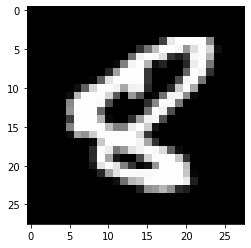

In [ ]:
img, label = test_dataset[1325]
plt.imshow(img[0], cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', predict(img))

Label: 5 - five , Predicted: 5 - five


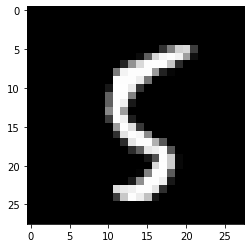

In [ ]:
img, label = test_dataset[182]
plt.imshow(img[0], cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', predict(img))

Label: 8 - eight , Predicted: 8 - eight


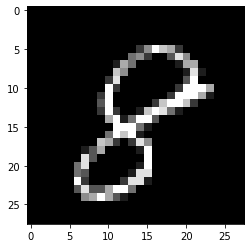

In [ ]:
img, label = test_dataset[4096]
plt.imshow(img[0], cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', predict(img))

Label: 7 - seven , Predicted: 7 - seven


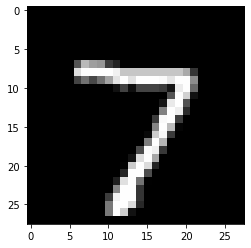

In [ ]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', predict(img))

Label: 6 - six , Predicted: 6 - six


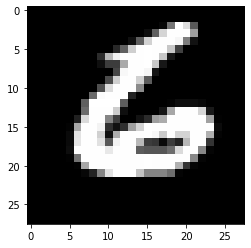

In [ ]:
img, label = test_dataset[9999]
plt.imshow(img[0], cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', predict(img))

Label: 1 - one , Predicted: 1 - one


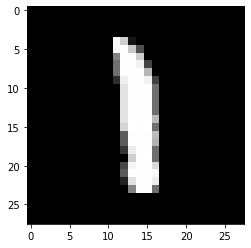

In [ ]:
img, label = test_dataset[777]
plt.imshow(img[0], cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', predict(img))

In [ ]:
print('Accuracy of the model after', num_epochs, 'epochs is', history[-1]['accuracy'] * 100, '%')

Accuracy of the model after 20 epochs is 99.91670846939087 %
